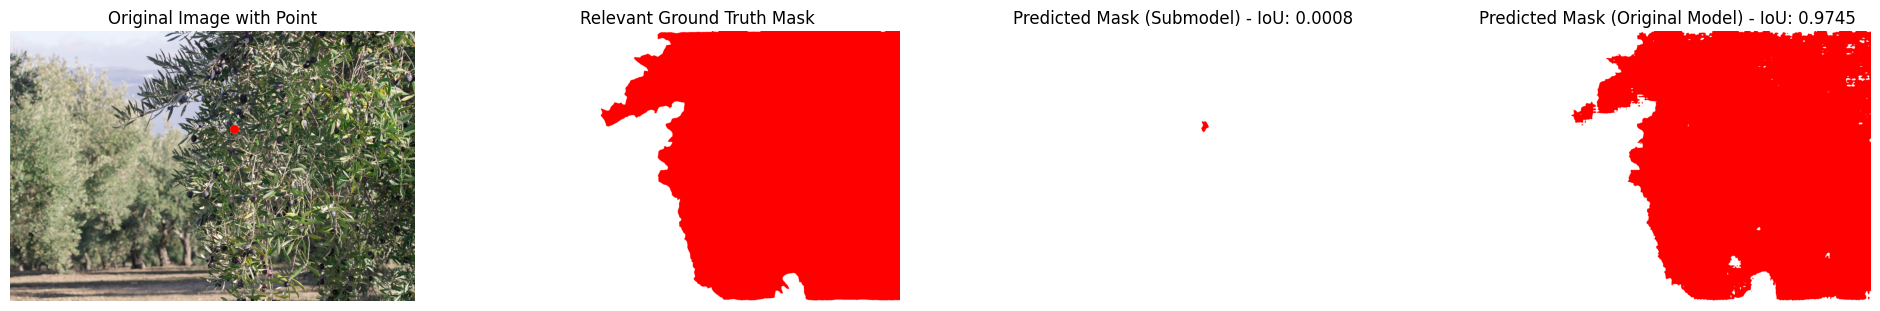

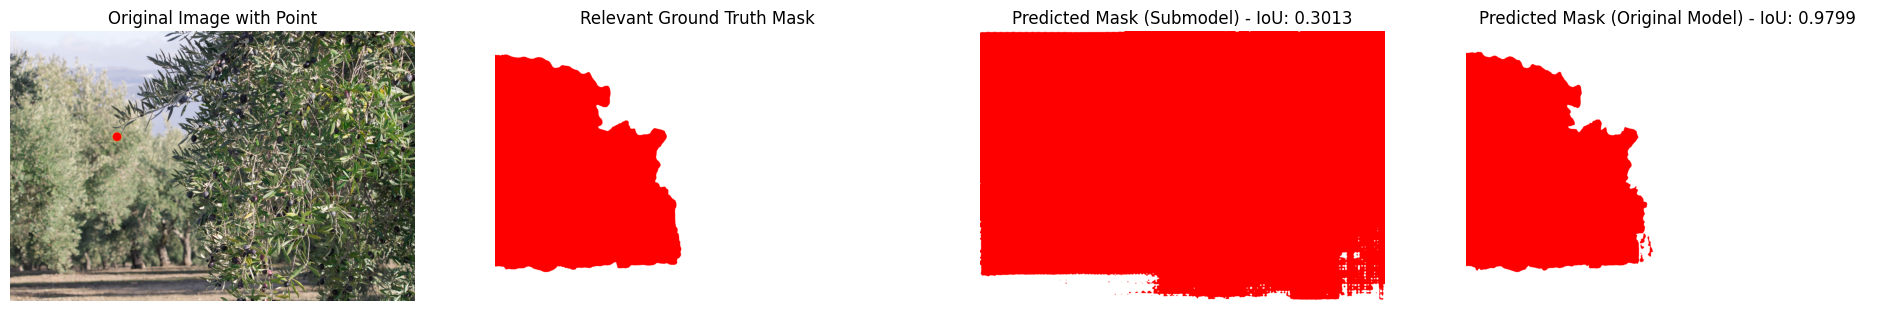

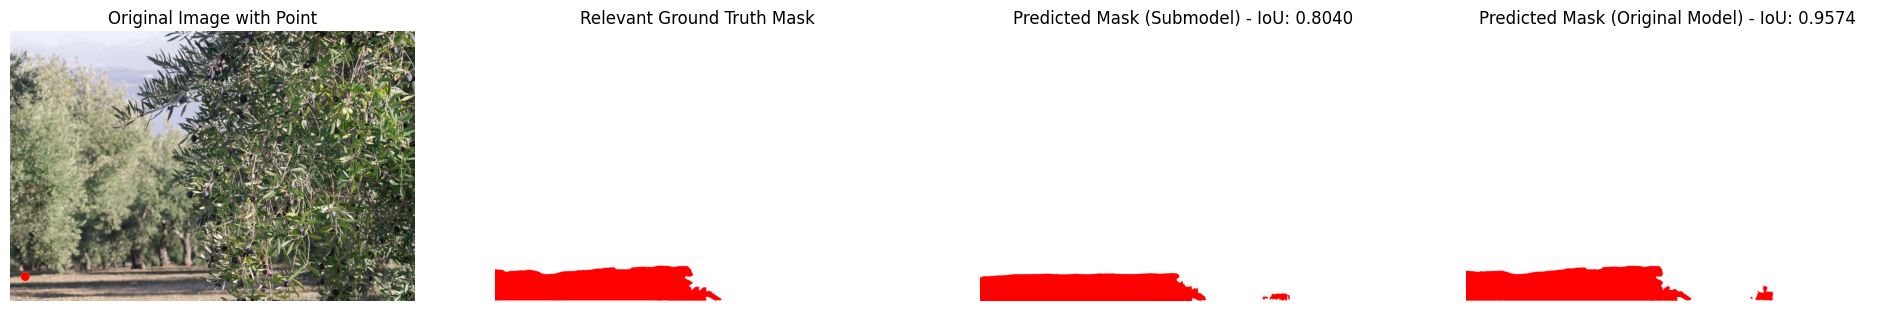

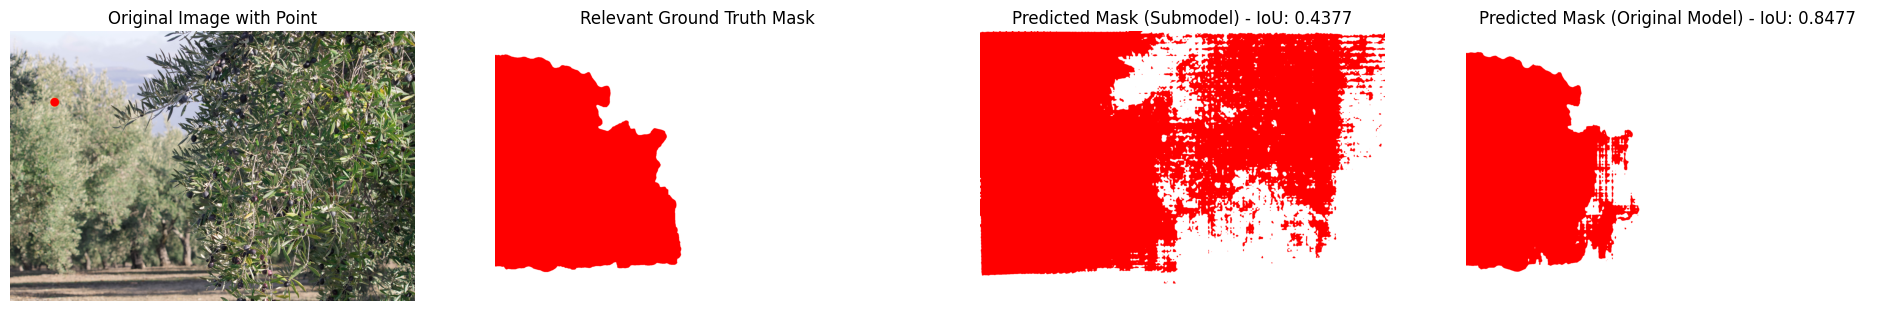

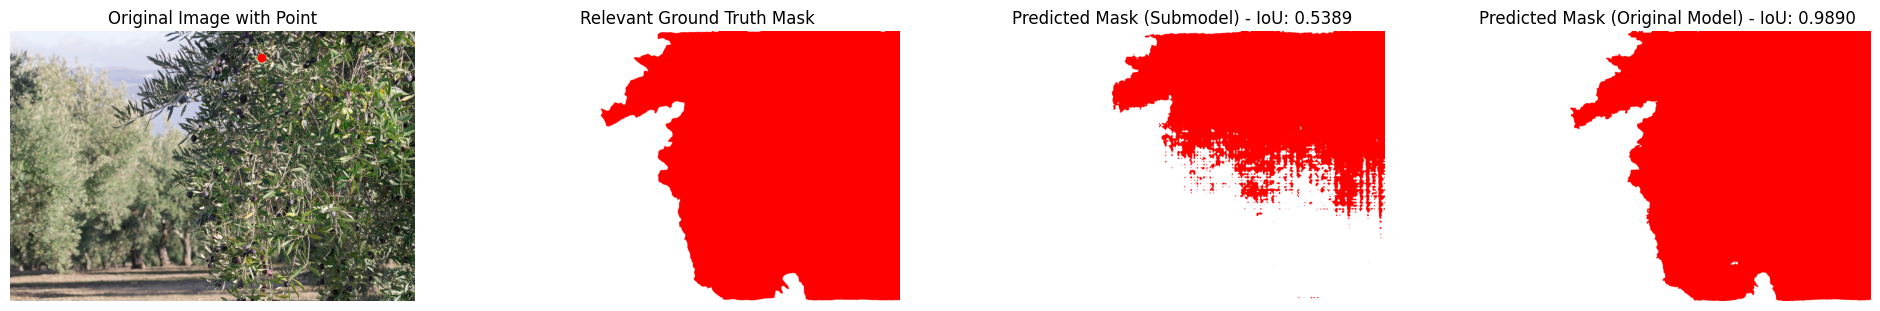

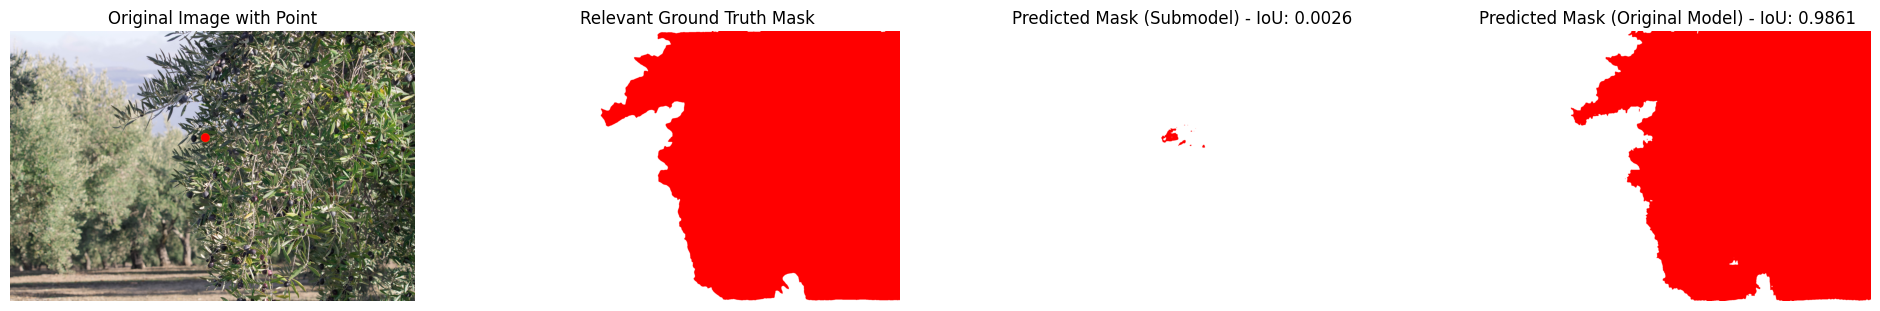

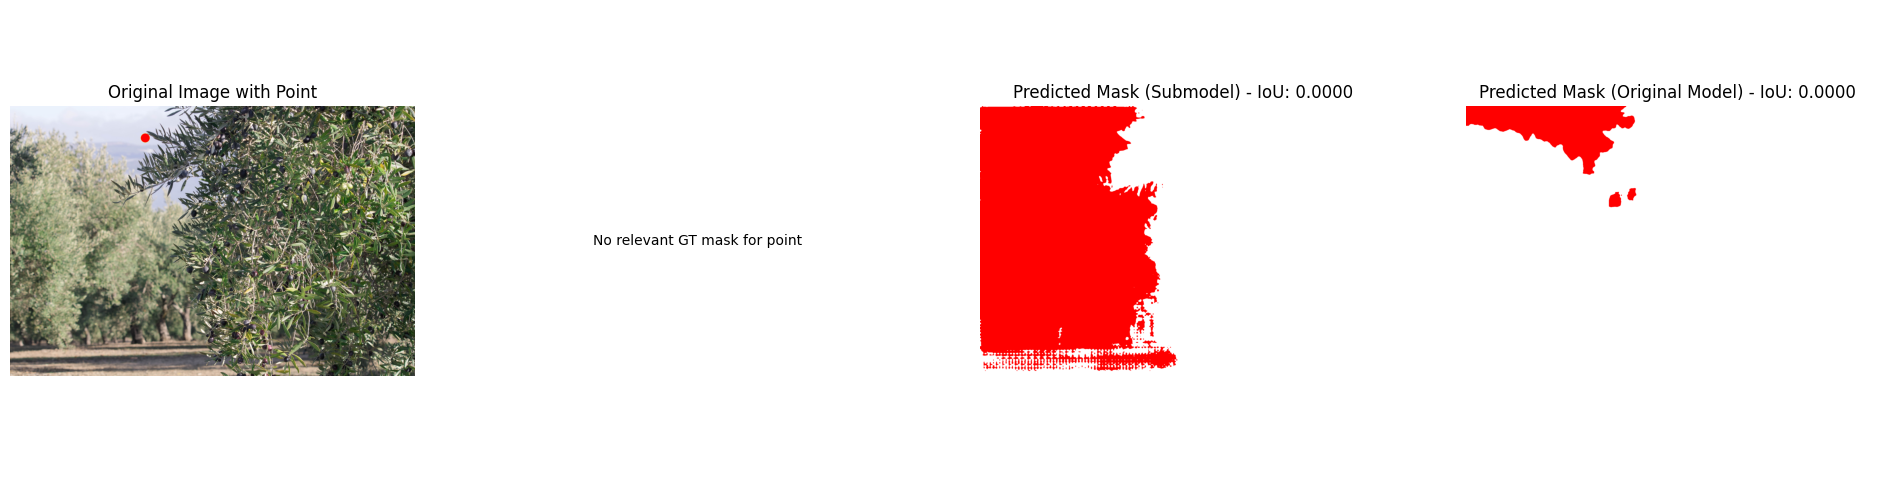

In [ ]:
import os
import random
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from pycocotools import mask as coco_mask
from transformers import SamModel, SamProcessor, pipeline
from raffm import RaFFM
import torch
import gc
import torch
from PIL import Image
import requests
import torchvision.transforms as transforms


# Initialize the original SAM model and processor
original_model = SamModel.from_pretrained("facebook/sam-vit-huge").to("cuda")
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

# Initialize the mask generation pipeline for the original SAM model
original_generator = pipeline("mask-generation", model=original_model, device="cuda", image_processor=processor.image_processor)

# RaFFM configuration and submodel initialization
elastic_config = {
    "atten_out_space": [1280],
    "inter_hidden_space": [2048],
    "residual_hidden_space": [2048],
}
raffm_model = RaFFM(original_model, elastic_config=elastic_config)
submodel, params, config = raffm_model.random_resource_aware_model()
submodel_generator = pipeline("mask-generation", model=submodel, device="cuda", image_processor=processor.image_processor)

# img_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
# raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")
# input_points = [[[259, 500]]]  # 2D location of a window in the image

models = {"submodel": submodel, "original_model": original_model}

# inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to("cuda")
# with torch.no_grad():
#     outputs = models["submodel"](**inputs)

# masks = processor.image_processor.post_process_masks(
#     outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
# )
#scores = outputs.iou_scores


# # Define transformations to convert the PIL image to a torch tensor
# transform = transforms.ToTensor()

# # Apply the transformations to the image
# image_tensor = transform(raw_image)

# # Print the shape of the torch tensor
# print(image_tensor.shape)

# print(masks[0].shape)
# print(scores)

# iou_submodel = calculate_metrics(image_tensor, masks[0]) 

# with torch.no_grad():
#     outputs = models["original_model"](**inputs)
    
# masks = processor.image_processor.post_process_masks(
#     outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
# )
# scores = outputs.iou_scores


# print(len(masks))
# print(scores)



def get_image_info(dataset_directory, num_images=1):
    image_mask_pairs = []
    for filename in os.listdir(dataset_directory):
        if filename.endswith(".jpg"):
            image_path = os.path.join(dataset_directory, filename)
            mask_filename = filename.replace(".jpg", ".json")
            mask_path = os.path.join(dataset_directory, mask_filename)
            if os.path.exists(mask_path):
                image_mask_pairs.append((image_path, mask_path))
    selected_pairs = random.sample(image_mask_pairs, min(num_images, len(image_mask_pairs)))
    return selected_pairs

def get_ground_truth_masks(mask_path):
    binary_masks = []
    with open(mask_path, 'r') as json_file:
        mask_data = json.load(json_file)
    for annotation in mask_data['annotations']:
        rle_mask = annotation['segmentation']
        binary_mask = coco_mask.decode(rle_mask)
        binary_masks.append(binary_mask)
    return binary_masks

def calculate_metrics(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    iou = intersection / union if union != 0 else 0
    return iou

def show_mask_on_white_background(mask, ax):
    if mask is not None:
        h, w = mask.shape
        white_background = np.ones((h, w, 3), dtype=np.uint8) * 255
        mask_image = mask.reshape(h, w, 1) * np.array([255, 0, 0], dtype=np.uint8).reshape(1, 1, 3)
        white_background[mask_image[:, :, 0] > 0] = mask_image[mask_image[:, :, 0] > 0]
        ax.imshow(white_background)
    else:
        ax.text(0.5, 0.5, 'No mask detected', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.set_xticks([])
    ax.set_yticks([])

def point_in_mask(point, mask):
    x, y = point
    if mask[y, x] > 0:
        return True
    return False


dataset_directory = "SA1B"
selected_images = get_image_info(dataset_directory)




for image_path, mask_path in selected_images:
    original_image = Image.open(image_path).convert("RGB")
    ground_truth_masks = get_ground_truth_masks(mask_path)

    for _ in range(20):  # Process 20 random points
        
        
        
            
            
        image_for_display = original_image.copy()
        draw = ImageDraw.Draw(image_for_display)
        raw_image = np.array(original_image)
        # print("Raw image shape1", raw_image.shape)
        input_point = [random.randint(0, raw_image.shape[1]-1), random.randint(0, raw_image.shape[0]-1)]
        #input_point = [259, 500]  # 2D location of a window in the image

        draw.ellipse((input_point[0]-25, input_point[1]-25, input_point[0]+25, input_point[1]+25), fill='red', outline='yellow')


        relevant_gt_mask = None
        for gt_mask in ground_truth_masks:
            if point_in_mask(input_point, gt_mask):
                relevant_gt_mask = gt_mask
                break
        input_points = [[input_point]]
                
        inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to("cuda")
        
        transform = transforms.ToTensor()
        # Apply the transformations to the image
        image_tensor = transform(raw_image)
        # # Print the shape of the torch tensor
        # print("Raw image shape", image_tensor.shape)
        # print("input points",input_points )
        with torch.no_grad():
            submodel_outputs = models["submodel"](**inputs)
            submodel_masks = processor.image_processor.post_process_masks(
                submodel_outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
             )
            
        with torch.no_grad():
            original_outputs = models["original_model"](**inputs)
            
            model_masks = processor.image_processor.post_process_masks(
                original_outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
            )
            
        # print("submodel_masks", submodel_masks[0].shape)
        # print("model_masks", model_masks[0].shape)
        
        submodel_predicted_mask = submodel_masks[0].squeeze(0).squeeze(0).cpu()[1] if submodel_masks else None
        original_predicted_mask = model_masks[0].squeeze(0).squeeze(0).cpu()[1] if model_masks else None
        
        # print("submodel_predicted_mask", submodel_predicted_mask.shape)
        # print("original_predicted_mask", original_predicted_mask.shape)
       
        
        # print("Submodel_shape", submodel_predicted_mask.shape if submodel_predicted_mask != None else None)
        # print("model_shape", original_predicted_mask.shape if original_predicted_mask != None else None)
        # print("relevent", relevant_gt_mask.shape if relevant_gt_mask != None else None)
      
        # # submodel_predicted_mask = submodel_outputs[0].cpu()[-2:] if submodel_outputs else None
        # # original_predicted_mask = original_outputs[0].cpu()[-2:] if original_outputs else None
        # submodel_predicted_mask = submodel_outputs[0].squeeze().cpu()[-2:] if submodel_o utputs else None
        # original_predicted_mask = original_outputs[0].squeeze().cpu()[-2:] if original_outputs else None



        iou_submodel = calculate_metrics(submodel_predicted_mask, relevant_gt_mask) if relevant_gt_mask is not None and submodel_predicted_mask is not None else 0
        iou_original = calculate_metrics(original_predicted_mask, relevant_gt_mask) if relevant_gt_mask is not None and original_predicted_mask is not None else 0

        plt.figure(figsize=(24, 6))
        plt.subplot(1, 4, 1)
        plt.imshow(image_for_display)
        plt.title('Original Image with Point')
        plt.axis('off')

        plt.subplot(1, 4, 2)
        if relevant_gt_mask is not None:
            show_mask_on_white_background(relevant_gt_mask, plt.gca())
            plt.title('Relevant Ground Truth Mask')
        else:
            plt.text(0.5, 0.5, 'No relevant GT mask for point', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.axis('off')

        plt.subplot(1, 4, 3)
        if submodel_predicted_mask is not None:
            show_mask_on_white_background(submodel_predicted_mask, plt.gca())
            plt.title(f'Predicted Mask (Submodel) - IoU: {iou_submodel:.4f}')
        else:
            plt.text(0.5, 0.5, 'Submodel detected no mask', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.axis('off')

        plt.subplot(1, 4, 4)
        if original_predicted_mask is not None:
            show_mask_on_white_background(original_predicted_mask, plt.gca())
            plt.title(f'Predicted Mask (Original Model) - IoU: {iou_original:.4f}')
        else:
            plt.text(0.5, 0.5, 'Original Model detected no mask', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.axis('off')

        plt.show()
